In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

In [8]:
batch_size = 128

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

train_dataset = datasets.CIFAR10(
    root='../data', 
    train=True, 
    download=True, 
    transform=train_transform
)
test_dataset = datasets.CIFAR10(
    root='../data', 
    train=False, 
    download=True, 
    transform=test_transform
)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=24, pin_memory=True)
test_loader = data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=24, pin_memory=True)

一个批次的图像形状: torch.Size([128, 3, 32, 32])
一个批次的标签形状: torch.Size([128])


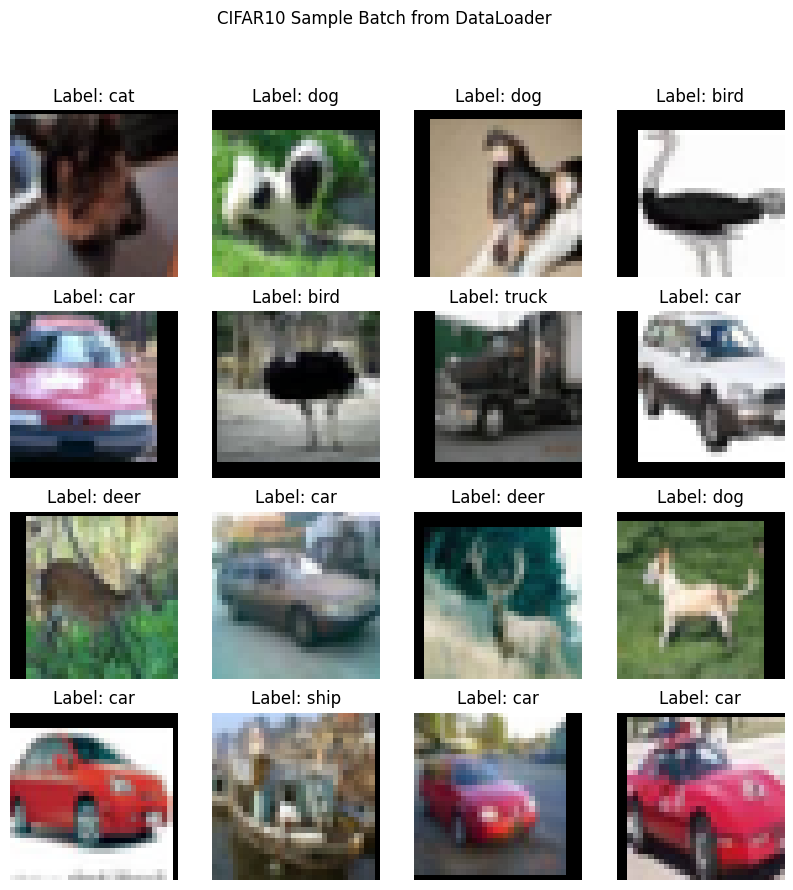

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"一个批次的图像形状: {images.shape}") # [batch_size, 3, 32, 32]
print(f"一个批次的标签形状: {labels.shape}") # [batch_size]

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)

    img = images[i].permute(1, 2, 0) * torch.tensor(stats[1]) + torch.tensor(stats[0])
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.numpy())
    plt.title(f"Label: {classes[labels[i].item()]}")
    plt.axis('off')
plt.suptitle("CIFAR10 Sample Batch from DataLoader")
plt.show()

In [10]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(256, 10)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.classifier(x)
        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SimpleMLP().to(device)
model.eval()
test_acc_sum, t_batches = 0.0, 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_acc_sum += (output.argmax(dim=1) == target).float().mean().item()
        t_batches += 1
    test_avg_acc = test_acc_sum / t_batches
print(f'初始模型在测试集上的平均准确率: {test_avg_acc:.4f}')

Using device: cuda
初始模型在测试集上的平均准确率: 0.1208


In [12]:
epochs = 100
lr = 0.1
weight_decay = 5e-4 

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss()

print('Start training...')
start_time = time.time()

for epoch in range(epochs):
    model.train()  
    running_loss, running_acc, n_batches = 0.0, 0.0, 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += (output.argmax(dim=1) == target).float().mean().item()
        n_batches += 1

    scheduler.step()

    model.eval()
    test_loss_sum, test_acc_sum, t_batches = 0.0, 0.0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss_sum += loss.item()
            test_acc_sum += (output.argmax(dim=1) == target).float().mean().item()
            t_batches += 1

    avg_loss = running_loss / len(train_loader)
    avg_acc = running_acc / n_batches
    test_avg_loss = test_loss_sum / t_batches
    test_avg_acc = test_acc_sum / t_batches
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, Test Loss: {test_avg_loss:.4f}, Test Acc: {test_avg_acc:.4f}')

print(f"Training complete in {time.time() - start_time:.2f}s!")

Start training...
Epoch [1/100], Train Loss: 2.1786, Train Acc: 0.2645, Test Loss: 1.7904, Test Acc: 0.3508
Epoch [2/100], Train Loss: 1.8244, Train Acc: 0.3304, Test Loss: 1.6434, Test Acc: 0.4051
Epoch [3/100], Train Loss: 1.7331, Train Acc: 0.3679, Test Loss: 1.5929, Test Acc: 0.4218
Epoch [4/100], Train Loss: 1.6737, Train Acc: 0.3934, Test Loss: 1.5072, Test Acc: 0.4598
Epoch [5/100], Train Loss: 1.6320, Train Acc: 0.4089, Test Loss: 1.4786, Test Acc: 0.4661
Epoch [6/100], Train Loss: 1.6093, Train Acc: 0.4188, Test Loss: 1.4779, Test Acc: 0.4692
Epoch [7/100], Train Loss: 1.5873, Train Acc: 0.4270, Test Loss: 1.4495, Test Acc: 0.4806
Epoch [8/100], Train Loss: 1.5715, Train Acc: 0.4323, Test Loss: 1.4381, Test Acc: 0.4849
Epoch [9/100], Train Loss: 1.5640, Train Acc: 0.4355, Test Loss: 1.4106, Test Acc: 0.4845
Epoch [10/100], Train Loss: 1.5570, Train Acc: 0.4368, Test Loss: 1.4127, Test Acc: 0.4923
Epoch [11/100], Train Loss: 1.5464, Train Acc: 0.4432, Test Loss: 1.4296, Test Ac

In [13]:
model.eval()

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Final Test Acc: {accuracy:.2f}%')
print("Evaluation complete!")

Final Test Acc: 63.83%
Evaluation complete!


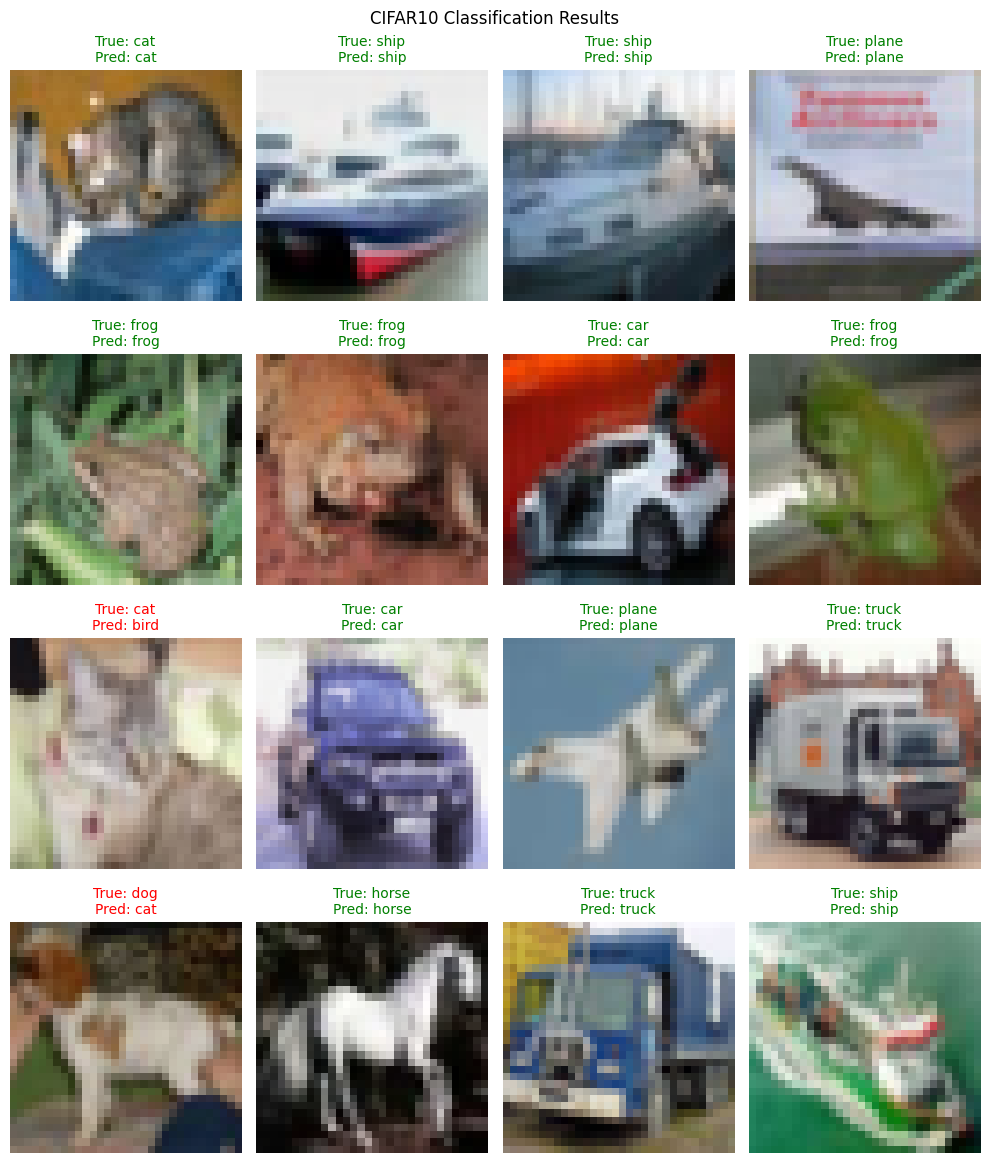

In [14]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

model.eval()
with torch.no_grad():
    images_dev = images.to(device)
    logits = model(images_dev)
    predicted = torch.argmax(logits, dim=1)
    predicted = predicted.cpu()

plt.figure(figsize=(10, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # 反归一化
    img = images[i].permute(1, 2, 0) * torch.tensor(stats[1]) + torch.tensor(stats[0])
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.numpy())

    label_text = f"True: {classes[labels[i].item()]}\nPred: {classes[predicted[i].item()]}"

    color = 'green' if labels[i].item() == predicted[i].item() else 'red'
    plt.title(label_text, color=color, fontsize=10)
    plt.axis('off')

plt.suptitle("CIFAR10 Classification Results", fontsize=12)
plt.tight_layout()
plt.show()